In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import pandas as pd
from tqdm import tqdm
from scipy import constants

r =  1.4048115940347137e-06
temp = 293
rho = 4200
rho_f = 789
eta = 0.36e-3
mass = 4/3 *np.pi *r**3*rho + 2/3 *np.pi *r**3*rho_f

In [2]:
# SIMULATIONS

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []

for chunk in pd.read_csv(r'C:\Users\mct2723\Desktop\Repos\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep_sim = df['real_timestep_s'].values[0]
positions_sim = []
velocities_sim = []
for i in range(len(position_cols)):
    positions_sim.append(df[position_cols[i]].astype(float).values)
    velocities_sim.append(df[velocity_cols[i]].astype(float).values)

# print(f"Positions shape: {positions_sim.shape}")
# print(f"Velocities shape: {velocities_sim.shape}")

bin_num_sim = 30 # why is the bin number > 50 causing an error??
true_time_step = timestep_sim * bin_num_sim

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

print("len of traces is " + str(len(traces_sim[0])))

v_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    v_traces_sim.append(series)

len of traces is 595551


sqrt kT/m is 0.0002753498819746064
vel std is 0.00027577504070964737
length of history is 5955
length of trace is 595551
speed idx sim: 2336
total hist idx: 2295


100%|█████████▉| 2292/2295 [01:18<00:00, 26.80it/s]

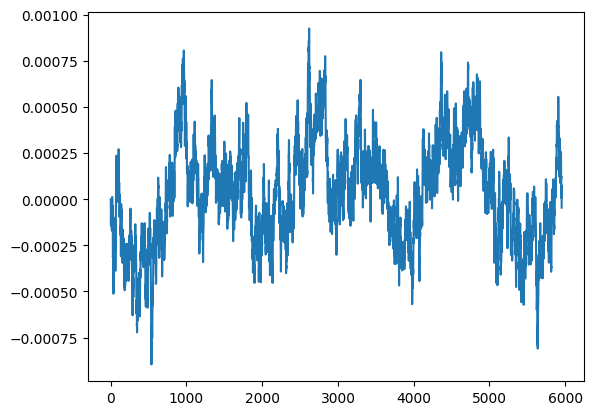

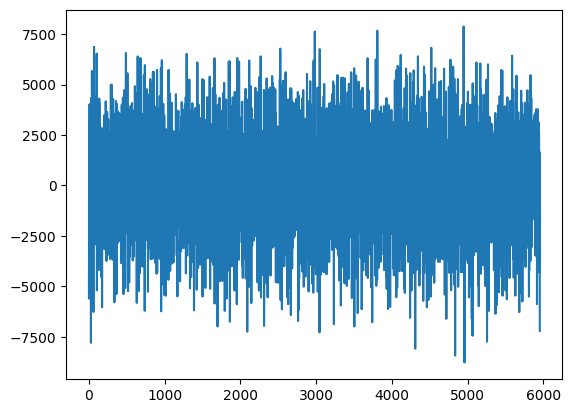

100%|██████████| 2295/2295 [01:19<00:00, 28.99it/s]


len of gamma mean 2295


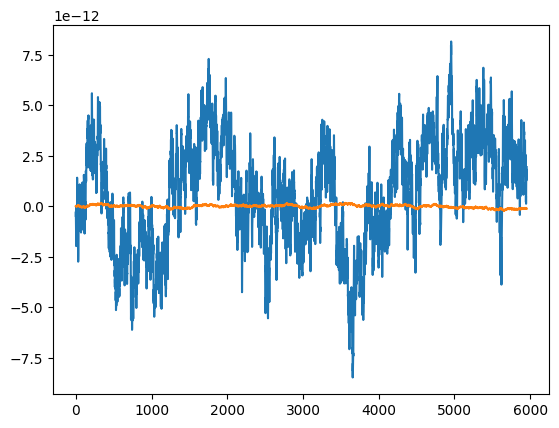

length of history is 5955
length of trace is 595551
speed idx sim: 2109
total hist idx: 2069


100%|█████████▉| 2068/2069 [01:04<00:00, 31.65it/s]

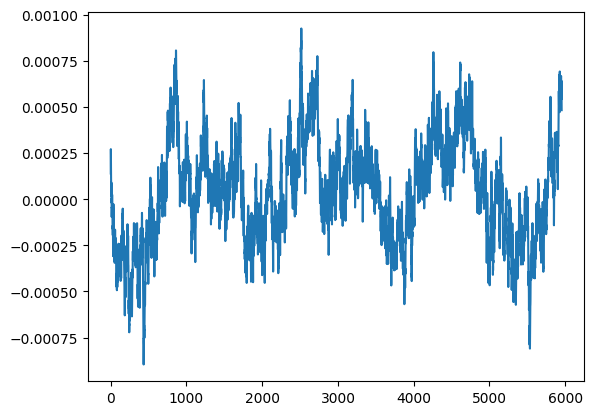

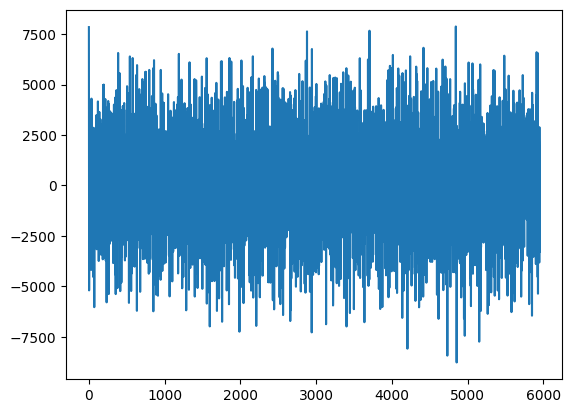

100%|██████████| 2069/2069 [01:04<00:00, 31.96it/s]

len of gamma mean 2069


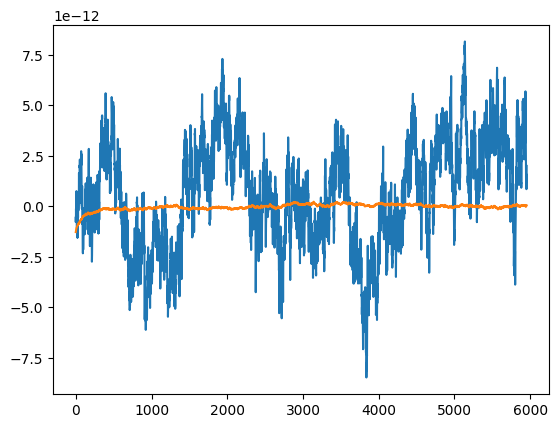

length of history is 5955
length of trace is 595551
speed idx sim: 1444
total hist idx: 1413


100%|█████████▉| 1412/1413 [00:44<00:00, 31.83it/s]

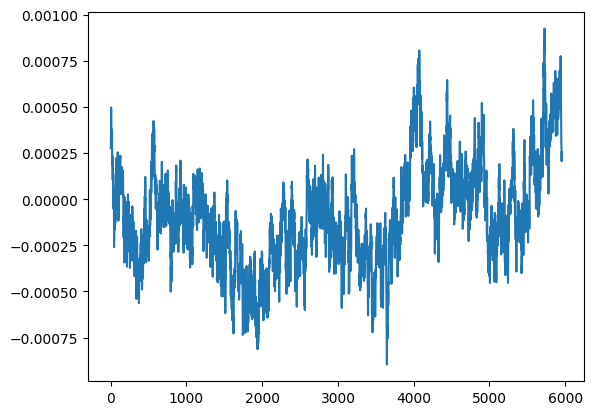

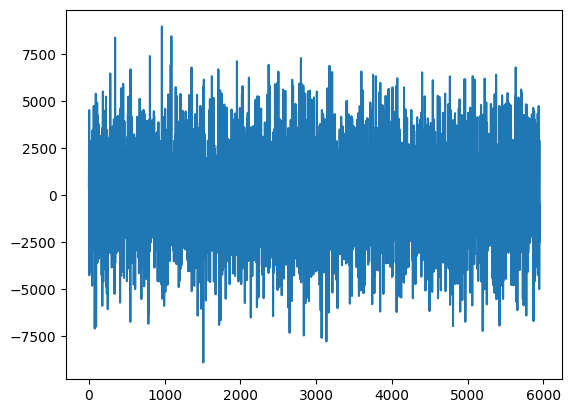

100%|██████████| 1413/1413 [00:44<00:00, 31.99it/s]

len of gamma mean 1413


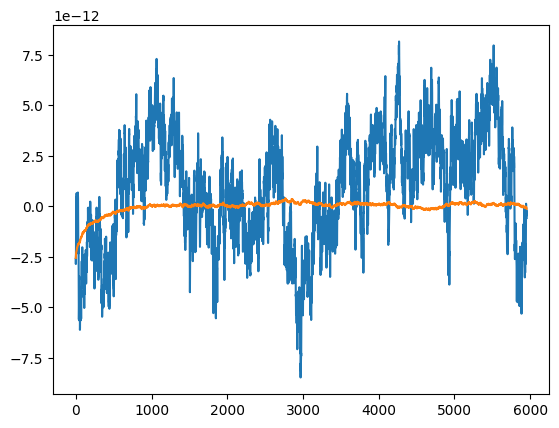

In [8]:
from scipy.integrate import simpson
from scipy.integrate import cumulative_simpson

def get_acceleration(velocity, dt, v_prev = 0):

    acceleration = np.zeros_like(velocity)

    if velocity.size == 1:
        acceleration[0] = (velocity[0] - v_prev) / dt
        return acceleration

    acceleration = np.zeros_like(velocity)

    # Use forward difference at the first point
    acceleration[0] = (velocity[1] - velocity[0]) / dt

    # Use centered difference for the middle points
    acceleration[1:-1] = (velocity[2:] - velocity[:-2]) / (2 * dt)

    # Use backward difference at the last point
    acceleration[-1] = (velocity[-1] - velocity[-2]) / dt

    return acceleration

print("sqrt kT/m is " + str(np.sqrt(constants.k*temp/mass)))
print("vel std is " + str(np.std(v_traces_sim[0])))
# SIM PART 2
vos = [0, .5, 1]
tol = .005

far = -4
close = -7.5

times = np.logspace(close, far, 200)

far_boundary = 10**(far)
close_boundary = 10**(close)

hist_len = int(far_boundary/true_time_step)

sim_histories = []
first = True
all_forward_basset_by_parts = []
all_forward_basset_main = []
all_gamma = []
all_by_parts_hist_basset_integrals = []
all_v_0_forward_basset_correction = []
# integrand = v / t**(1.5)

for speed in vos:
    v_0 = speed*np.sqrt(constants.k*temp/mass)
    print("length of history is " + str(hist_len) )
    print("length of trace is " + str(len(v_traces_sim[0])))
    speed_histories = []
    forward_basset_by_parts_main = []
    by_parts_hist_bassets_integrals_of_speed = []
    forward_basset_main = []
    gamma_func_of_speed = []
    basset_forward_main_v_0_correction_by_speed = []
    v_units = (speed * np.sqrt(constants.k*temp/mass))
    for i in range(len(traces_sim)):
        speed_tolerance = tol * np.sqrt(constants.k*temp/mass)
        v_indices = np.where((v_traces_sim[i] < v_units + speed_tolerance) & (v_traces_sim[i] > v_units - speed_tolerance))[0]
        print("speed idx sim: " + str(len(v_indices)))

        hist_idx = []
        for idx in v_indices:
            if idx - hist_len > 0 and idx + int(10**far/true_time_step) < len(v_traces_sim[0]):
                hist_idx.append(idx)

        print("total hist idx: " + str(len(hist_idx)))

        for idx in tqdm(hist_idx):
            v_hist = v_traces_sim[i][idx - hist_len: idx]

            t_hist = -1*np.linspace(0, far_boundary, len(v_hist))[::-1] #np.arange(int(close_boundary*fs_sim), hist_len + 1)*(1/fs_sim)
            forward_basset_by_parts = []
            by_parts_hist_basset_integrals = []
            forward_basset = []

            for t in times:
                integrand = v_hist / (2*(t-t_hist)**(1.5))

                total = simpson(integrand, x=t_hist)   # here the first "look" goes over the whole history window
                by_parts_hist_basset_integrals.append(total)

                # we need to convert t in times to an index for v
                # v traces sim has the true timestep. t is just some time in units t
                v_forward = v_traces_sim[i][idx: idx + int(t/true_time_step)]

                a_forward = get_acceleration(v_forward, true_time_step, v_prev = v_traces_sim[i][idx-1])
                if t==times[-1] and idx==hist_idx[-1]:
                    plt.plot(v_forward)
                    plt.show()
                    plt.plot(a_forward)
                    plt.show()
                # this line needs work
                t_forward = np.arange(1, len(v_forward)+1)*true_time_step

                integrand_forward = v_forward/(2*(t-t_forward)**(1.5))
                total_forward = simpson(integrand_forward, x=t_forward) # Here the first look goes over just one point...

                forward_basset_by_parts.append(total_forward)

                integrand_a = a_forward/((t-t_forward)**(0.5))

                total_a = simpson(integrand_a, x=t_forward)
                forward_basset.append(total_a)

            #
            # if first:
            #     plt.plot(times, 6*r**2*np.sqrt(np.pi * eta * rho_f)*np.array(decay_integrals))
            #     plt.axhline(mass*v_0)
            #     plt.xscale('log')
            #     plt.show()

            forward_basset_by_parts_main.append(forward_basset_by_parts)
            forward_basset_main.append(forward_basset)
            by_parts_hist_bassets_integrals_of_speed.append(by_parts_hist_basset_integrals)
            gamma_func_of_speed.append(-6*np.pi*r*eta*v_traces_sim[i][idx+int(times[0]/true_time_step):idx+int(times[-1]/true_time_step)])
            # integrand2 = v / (2*(t_hist)**(1.5))
            # total = simps(integrand2, t_hist)
            # cumlutive = cumtrapz(integrand2, t_hist)
            # speed_histories.append(total)
            #
            # if first:
            #     plt.plot(t_hist, v*1000, label = "scaled velocity")
            #     plt.plot(t_hist[1:], cumlutive, label = "cumulative integral")
            #     plt.axhline(total, label = "total integral")
            #     plt.xscale('log')
            #     plt.legend()
            #     plt.title("Log Scale")
            #     plt.show()
            #     plt.plot(t_hist, v*1000, label = "scaled velocity")
            #     plt.plot(t_hist[1:], cumlutive, label = "cumulative integral")
            #     plt.axhline(total, label = "total integral")
            #     plt.xscale('linear')
            #     plt.legend()
            #     plt.title("Linear Scale")
            #     plt.show()
            #     first = False
    # sim_histories.append(speed_histories)

    print("len of gamma mean " + str(len(gamma_func_of_speed)))
    plt.plot(gamma_func_of_speed[0])
    plt.plot(np.mean(gamma_func_of_speed, axis=0))
    plt.show()
    all_v_0_forward_basset_correction.append(-1 * 6 * r ** 2 * np.sqrt(np.pi * eta * rho_f) * v_units / np.sqrt(times))
    all_gamma.append(np.mean(gamma_func_of_speed, axis=0))
    all_forward_basset_by_parts.append(forward_basset_by_parts_main)
    all_forward_basset_main.append(forward_basset_main)
    all_by_parts_hist_basset_integrals.append(by_parts_hist_bassets_integrals_of_speed)
    # plt.hist(speed_histories, 100)
    # plt.title(f"Speed History {speed} STD")
    # plt.show()
    # print(6*r**2*np.sqrt(np.pi * eta * rho_f))
    # print((mass*v_0))
    # ratio = ((mass*v_0)+6*r**2*np.sqrt(np.pi * eta * rho_f)*np.mean(speed_histories))/(mass*v_0)
    # print("Ratio is " + str(ratio))


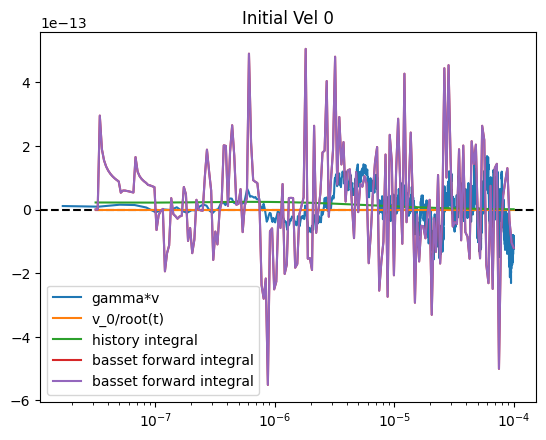

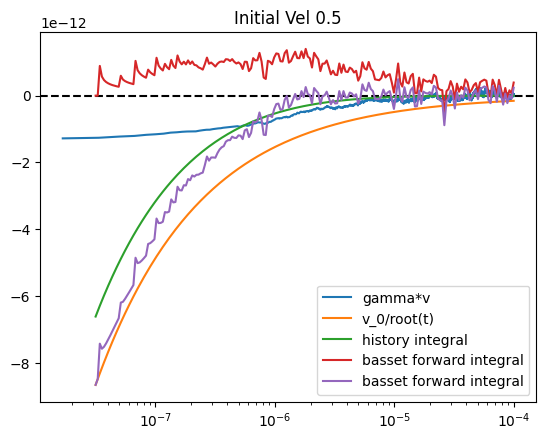

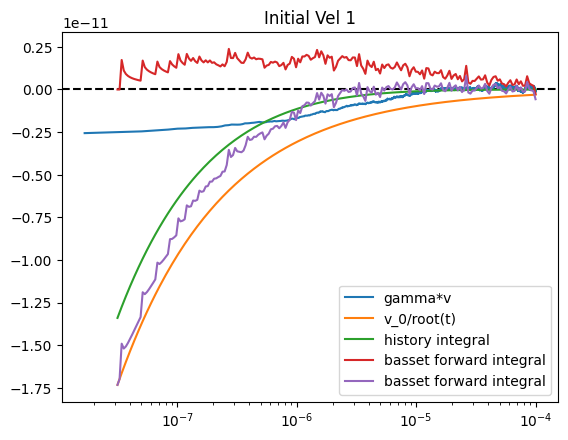

In [9]:

mean_forward_basset_by_parts = [np.mean(group, axis=0) for group in all_forward_basset_by_parts]
mean_by_parts_hist_arrays_basset = [np.mean(group, axis=0) for group in all_by_parts_hist_basset_integrals]
mean_forward_basset = [np.mean(group, axis=0) for group in all_forward_basset_main]
gamma_times = np.arange(int(10**close/true_time_step), int(10**far/true_time_step))*true_time_step

for i in range(len(mean_forward_basset_by_parts)):
    # v_0 = vos[i]*np.sqrt(constants.k*temp/mass)
    # force = mean_arrays[i]*6*r**2*np.sqrt(np.pi * eta * rho_f)
    # force_over_m = mean_arrays[i]*6*r**2*np.sqrt(np.pi * eta * rho_f)/mass
    # integrate = cumtrapz(force_over_m, times)
    # plt.plot(times[:-1], integrate, label="integrate")
    # plt.legend()
    # plt.axhline(v_0)
    # plt.show()
    plt.axhline(0, color='black', ls='--')
    plt.plot(gamma_times, all_gamma[i], label='gamma*v')
    plt.plot(times, all_v_0_forward_basset_correction[i], label='v_0/root(t)')
    ## plt.plot(times, mean_forward_basset_by_parts[i] * 6 * r ** 2 * np.sqrt(np.pi * eta * rho_f), label ="by parts basset forward integral")
    # This is the history integral by parts where we ignore the v_0 term since it cancels
    plt.plot(times, mean_by_parts_hist_arrays_basset[i] * -1 * 6 * r ** 2 * np.sqrt(np.pi * eta * rho_f), label ="history integral")
    plt.plot(times, mean_forward_basset[i] * -1 * 6 * r ** 2 * np.sqrt(np.pi * eta * rho_f), label ="basset forward integral")
    # This is the forward basset integral minus the v_0 term that comes out by parts and cancels with the other v_0 term
    plt.plot(times, mean_forward_basset[i] * -1 * 6 * r ** 2 * np.sqrt(np.pi * eta * rho_f) + all_v_0_forward_basset_correction[i], label ="basset forward integral")

    plt.title(f"Initial Vel {vos[i]}")
    # plt.axhline(mass*v_0, color = 'red', label = "M*v_0")
    plt.xscale('log')
    # plt.xlim(right=5e-7)
    plt.legend()
    plt.show()


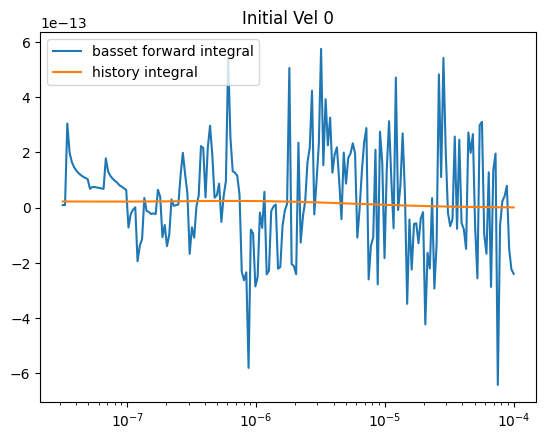

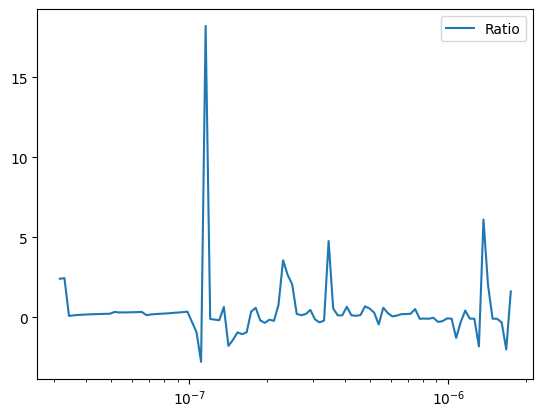

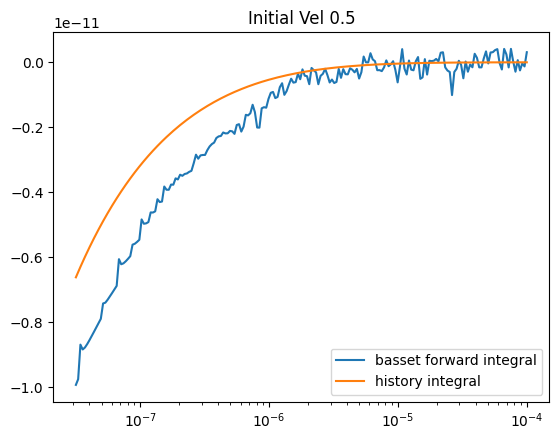

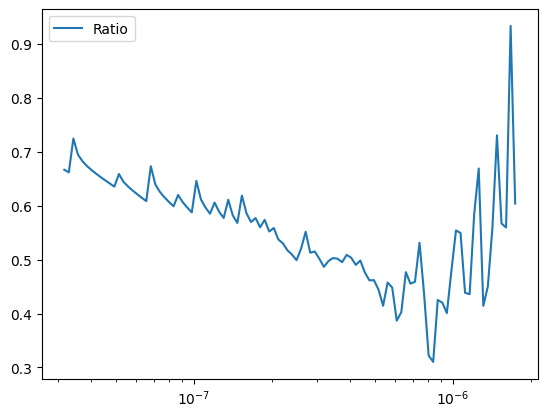

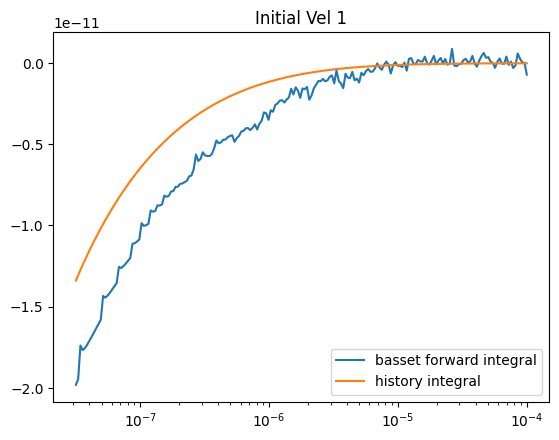

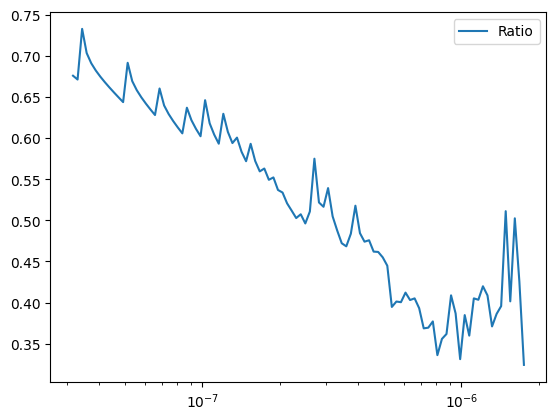

In [21]:
from scipy.interpolate import interp1d

for i in range(len(mean_forward_basset_by_parts)):
    interp_func = interp1d(gamma_times, all_gamma[i], kind='linear', bounds_error=False, fill_value='extrapolate')
    gamma_interp = interp_func(times)
    history = mean_by_parts_hist_arrays_basset[i] * -1 * 6 * r ** 2 * np.sqrt(np.pi * eta * rho_f)
    other_terms = mean_forward_basset[i] * -1 * 6 * r ** 2 * np.sqrt(np.pi * eta * rho_f) + all_v_0_forward_basset_correction[i] + gamma_interp
    plt.plot(times[:500], other_terms[:500], label ="basset forward integral")
    plt.plot(times[:500], history[:500], label ="history integral")

    plt.title(f"Initial Vel {vos[i]}")
    # plt.axhline(mass*v_0, color = 'red', label = "M*v_0")
    plt.xscale('log')
    # plt.xlim(right=5e-7)
    plt.legend()
    plt.show()

    plt.plot(times[:100], history[:100]/other_terms[:100], label ="Ratio")
    plt.xscale('log')
    # plt.xlim(right=3e-6)
    plt.legend()
    plt.show()
